In [1]:
# System libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# Data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning Libraries
import tensorflow as tf
import keras # İşte kral geri döndü

# Keras 3.0'da her şeyi doğrudan 'keras' kütüphanesinden çekiyoruz
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers

# Keras 3.0'da ImageDataGenerator keras_core'da değişti
# Kullanım: keras.preprocessing.image.ImageDataGenerator artık deprecated
# Alternatif: tf.keras.preprocessing.image.ImageDataGenerator veya tf.data API
try:
    from keras.preprocessing.image import ImageDataGenerator
except ImportError:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')
# Emin olmak için versiyonları görelim
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")

Modules loaded
TensorFlow: 2.20.0
Keras: 3.12.0


In [3]:
data_dir = r"C:\Users\olcay\Desktop\BLOODCELL\bloodcells_dataset"
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    if fold in ['ig', 'neutrophil']:
        continue
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df.head()

,filepaths,labels
0,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,basophil
1,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,basophil
2,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,basophil
3,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,basophil
4,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,basophil


In [11]:
df.tail()

,filepaths,labels
10863,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,platelet
10864,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,platelet
10865,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,platelet
10866,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,platelet
10867,C:\Users\olcay\Desktop\BLOODCELL\bloodcells_da...,platelet


In [5]:
df.shape

(10868, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  10868 non-null  object
 1   labels     10868 non-null  object
dtypes: object(2)
memory usage: 169.9+ KB


In [7]:
labelscount = df['labels'].value_counts().reset_index()
labelscount

,labels,count
0,eosinophil,3117
1,platelet,2348
2,erythroblast,1551
3,monocyte,1420
4,basophil,1218
5,lymphocyte,1214


<h1 style="font-size:40px; color:red;">
   !!! totalde 6 adet class var!!!
</h1>


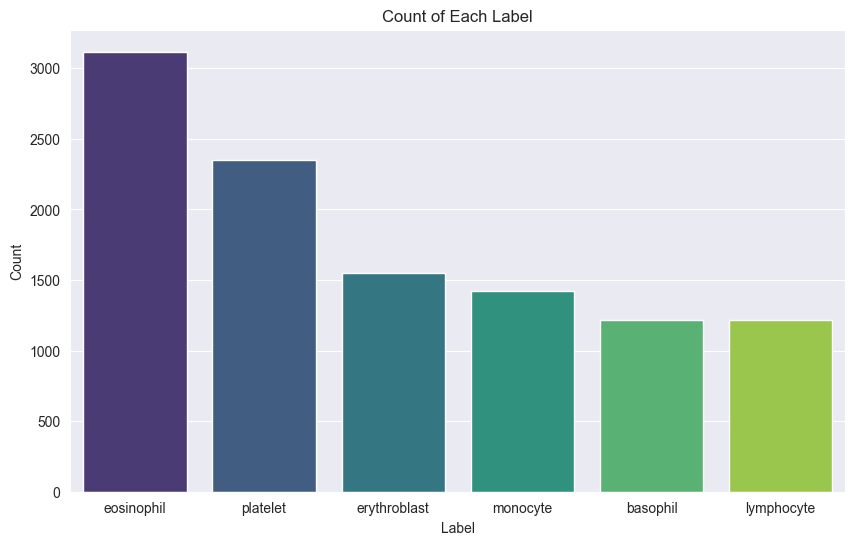

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(x='labels', y='count', data=labelscount, palette='viridis')

# Add title and labels
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

<h1 style="font-size:20px; color:blue;"> ">
   !ilk class'ta (eosinophil) log'lardan kontrol et eğer çok overfitting durumu olursa veriyi azaltalım!
</h1>

In [13]:
train_df, dummy_df = train_test_split(df,  test_size= 0.3, shuffle= True, random_state= 43)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 43)

# %70 train, %15 valid, %15 test
print(f"Train shape: {train_df.shape}")
print(f"Valid shape: {valid_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (7607, 2)
Valid shape: (1630, 2)
Test shape: (1631, 2)


In [17]:
root_dir = "bolunmus_dataset"

splits = {
    "train": train_df,
    "valid": valid_df,
    "test":  test_df
}

for split_name, split_df in splits.items():
    for i, row in split_df.iterrows():

        img_path = row["filepaths"]
        label    = row["labels"]

        # Hedef klasör: bolunmus_dataset/train/classA/
        target_dir = os.path.join(root_dir, split_name, label)
        os.makedirs(target_dir, exist_ok=True)

        # Dosya adı + hedef tam yol
        file_name = os.path.basename(img_path)
        target_path = os.path.join(target_dir, file_name)

        # Kopyala
        shutil.copy(img_path, target_path)

print("✓ Train / Valid / Test klasörlere kaydedildi!")

✓ Train / Valid / Test klasörlere kaydedildi!


In [15]:
df.columns


Index(['filepaths', 'labels'], dtype='object')

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 7607 validated image filenames belonging to 6 classes.
Found 1630 validated image filenames belonging to 6 classes.
Found 1631 validated image filenames belonging to 6 classes.


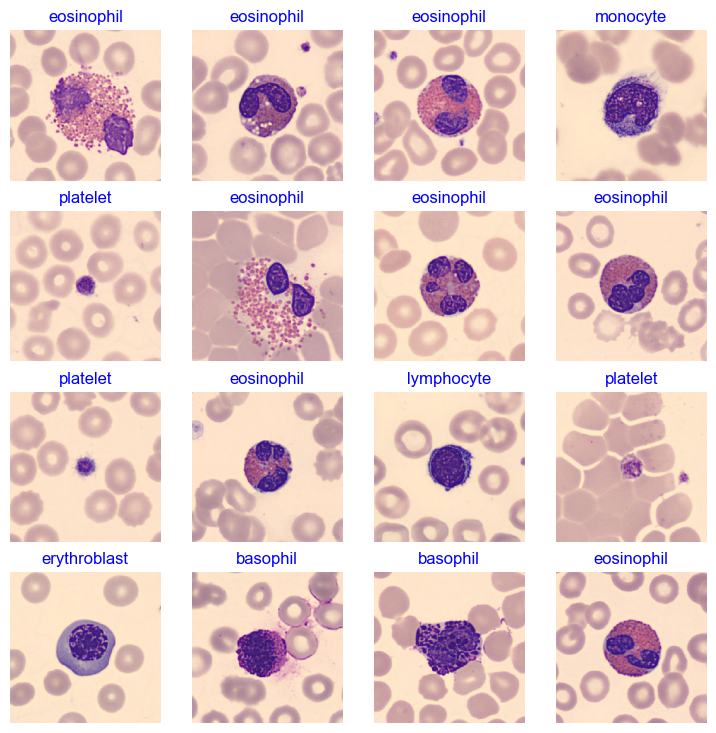

In [20]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (9, 9))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
class_count = len(train_gen.class_indices)

model = Sequential([
    # 1. CNN BLOKU
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=img_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # 2. CNN BLOKU
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # 3. CNN BLOKU
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Tam bağlantılı katmanlar
    Flatten(),
    Dropout(0.3),                           # Overfitting'i azaltır
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(class_count, activation='softmax') # Çıkış katmanı
])

model.compile(
    optimizer=Adam(learning_rate=0.001),    # Learning rate optimize edildi
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,614 (49.36 MB)

 Trainable params: 12,939,910 (49.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_gen,
    epochs=40,
    validation_data=valid_gen,
    callbacks=[es, lr],
    shuffle=False
)


Epoch 1/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 299s 624ms/step - accuracy: 0.9164 - loss: 0.2783 - val_accuracy: 0.8362 - val_loss: 0.6532 - learning_rate: 5.0000e-04
Epoch 2/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 302s 635ms/step - accuracy: 0.9740 - loss: 0.0926 - val_accuracy: 0.9387 - val_loss: 0.3506 - learning_rate: 5.0000e-04
Epoch 3/40
203/476 ━━━━━━━━━━━━━━━━━━━━ 2:49 623ms/step - accuracy: 0.9824 - loss: 0.0626

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

TEST EDELİM!

In [ ]:
# Tüm veri üzerinde değerlendirme yap
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
# Model değerlendirmesini özetle
print("\n" + "="*50)
print("MODEL EĞİTİMİ TAMAMLANDI")
print("="*50)
print(f"\nEn iyi Validation Loss: Epoch {np.argmin(val_loss) + 1}")
print(f"En iyi Validation Accuracy: Epoch {np.argmax(val_acc) + 1}")
print(f"\nFinal Test Accuracy: {test_score[1]:.4f}")
print(f"Final Test Loss: {test_score[0]:.4f}")
print("\n" + "="*50)


# İsteğe bağlı: Modeli kaydet# model.save('blood_cell_classifier.h5')